# Unified Model, Multiple Weighted Strategic Agents, Uniform Opinion Leader Network

James Yu, 12 July 2024, updated 1 September 2024

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def should_terminate(bundles, eps):
    return all([np.allclose(b[0], b[1], rtol = eps, atol = eps) for b in bundles])

def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    eps = np.sqrt(10**-11)
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        historical_K.insert(0, K_new)
        historical_k.insert(0, k_new)
        historical_kappa.insert(0, kappa_new)
        if should_terminate([(K_t, K_new), (k_t, k_new), (kappa_t, kappa_new)], eps):
            return historical_K[0], historical_k[0], historical_kappa[0]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new

In [5]:
def optimal(X_init, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, eps):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(int)
    
    M_ = M(K_ss, B, R, L, delta)
    H_ = H(B, K_ss, A, L)
    E_ = E(M_, H_)
    G_ = G(A, B, E_, L, n)
    F_ = [F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n) for l in range(L)]
    g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
    
    i = 0
    while True:
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F_[l]
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if l == L - 1 and np.allclose(X_t[l], X_new, rtol = eps, atol = eps):
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(A, b1, b2, alpha1, alpha2, delta, c, X_0_1, tol = 10**-11):
    A_SVD = np.linalg.svd(A)
    VT = A_SVD.Vh
    V1 = VT.T
    if V1[0, 0] < 0: # if negative, flip sign
        V1 = -1 * V1
    print("V:")
    print(V1)
    print()
    print("U:")
    if V1[0, 0] < 0: # if negative, flip sign
        print(-1 * A_SVD.U)
    else:
        print(A_SVD.U)
    print()
    print("S:")
    print(np.diag(A_SVD.S))
    print()
    print("U @ S @ V':")
    if V1[0, 0] < 0: # if negative, flip sign
        print((-1 * A_SVD.U) @ np.diag(A_SVD.S) @ V1.T)
    else:
        print(A_SVD.U @ np.diag(A_SVD.S) @ V1.T)
    print()
    
    X_0 = [X_0_1 - b1, X_0_1 - b2]
    n = A.shape[0] # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c * np.identity(n), c * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [alpha1 * np.identity(n), alpha2 * np.identity(n)] # B^l = a_l I_n
    x = [b1, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    
    K_ss, k_ss, kappa_ss = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol)
    xs, rs, payoffs = optimal(X_0, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, tol)

    tilde_K1 = (V1.T @ K_ss[0] @ V1) # tilde K1
    tilde_k1 = np.linalg.inv(2 * V1 @ tilde_K1) @ (2 * (b1 * np.ones((4, 1))).T @ K_ss[0] - k_ss[0]).T # tilde_k1
    tilde_K2 = (V1.T @ K_ss[1] @ V1) # tilde K2
    tilde_k2 = np.linalg.inv(2 * V1 @ tilde_K2) @ (2 * (b2 * np.ones((4, 1))).T @ K_ss[1] - k_ss[1]).T # tilde_k2
    tilde_xs_infty = V1.T @ (xs[0][-1] + b1) # projected limit opinions
    tilde_rs_1 = [V1.T @ r for r in rs[0]] # projected messages, influencer 1
    tilde_rs_2 = [V1.T @ r for r in rs[1]] # projected messages, influencer 2
    
    print("Network:")
    print(A)
    print()
    print("Unprojected Steady-State Opinions:")
    print(xs[0][-1] + b1)
    print("Projected Steady-State Opinions:")
    print(tilde_xs_infty)
    print()
    print("Projected Steady-State Messages:")
    print("1:")
    print(tilde_rs_1[-1])
    print()
    print("2:")
    print(tilde_rs_2[-1])
    print()
    print()
    print("Projected Messages:")
    print("1:")
    for tilde_r_1 in tilde_rs_1:
        print(tilde_r_1.T)
    print()
    print("2:")
    for tilde_r_2 in tilde_rs_2:
        print(tilde_r_2.T)
    print()
    print()
    print("Unprojected Steady-State Messages:")
    print("1:")
    print(rs[0][-1])
    print()
    print("2:")
    print(rs[1][-1])
    print()
    print()
    print("Unprojected Messages:")
    print("1:")
    for r_1_message in rs[0]:
        print(r_1_message.T)
    print()
    print("2:")
    for r_2_message in rs[1]:
        print(r_2_message.T)
    print()
    print()
    print("Total Payoffs:")
    print("1:", payoffs[0][-1])
    print("2:", payoffs[1][-1])
    print()
    print("Cumulative Payoffs:")
    print("1:")
    for payoff_1 in payoffs[0]:
        print(payoff_1)
    print()
    print("2:")
    for payoff_2 in payoffs[1]:
        print(payoff_2)
    print()
    print()
    print("Average of agendas:")
    print((b1+b2)/2)
    print()
    print("tilde_K^*:")
    print("1:")
    print(tilde_K1)
    print()
    print("2:")
    print(tilde_K2)
    print()
    print()
    print("tilde_k^*:")
    print("1:")
    print(tilde_k1)
    print()
    print("2:")
    print(tilde_k2)
    return xs, tilde_rs_1, tilde_rs_2, payoffs

In [7]:
def run_simulation_single_influencer(A, delta, c, x_0):
    A_SVD = np.linalg.svd(A)
    VT = A_SVD.Vh
    V1 = VT.T
    if V1[0, 0] < 0: # if negative, flip sign
        V1 = -1 * V1
    print("V:")
    print(V1)
    print()
    print("U:")
    if V1[0, 0] < 0: # if negative, flip sign
        print(-1 * A_SVD.U)
    else:
        print(A_SVD.U)
    print()
    print("S:")
    print(np.diag(A_SVD.S))
    print()
    print("U @ S @ V':")
    if V1[0, 0] < 0: # if negative, flip sign
        print((-1 * A_SVD.U) @ np.diag(A_SVD.S) @ V1.T)
    else:
        print(A_SVD.U @ np.diag(A_SVD.S) @ V1.T)
    print()
    
    n = len(x_0)
    eps = np.finfo(np.float64).eps
    I = np.identity(n)
    Q = I
    K_t = Q
    K_sequence = [K_t]
    
    while True: # generate solution matrices
        K_t_new = Q + delta * A.T @ (K_t - delta * (K_t @ np.linalg.inv(delta * K_t + c * I) @ K_t)) @ A
        K_sequence.insert(0, K_t_new)
        if np.allclose(K_t, K_t_new, rtol = eps, atol = eps): break
        K_t = K_t_new

    x_var = x_0
    x_ts = [x_var]
    r_ts = []
    K_ss = K_sequence[0]
    L_ss = -np.linalg.inv(delta * K_ss + c * I) @ (delta * K_ss) @ A
    
    payoff = 0
    cumulative_payoffs = []
    
    i = 0
    while True:
        r_t = L_ss @ x_var
        r_ts.append(r_t)
        p = -(x_var.T @ Q @ x_var + c * r_t.T @ r_t).item()
        payoff += delta**i * p
        cumulative_payoffs.append(payoff)
        x_var_new = A @ x_var + I @ r_t
        x_ts.append(x_var_new)
        if np.allclose(x_var, x_var_new, rtol = eps, atol = eps): break
        x_var = x_var_new
        i += 1

    tilde_K = (V1.T @ K_ss @ V1) # tilde K1
    tilde_xs_infty = V1.T @ x_ts[-1] # projected limit opinions
    tilde_rs = [V1.T @ r for r in r_ts] # projected messages
    
    print("Network:")
    print(A)
    print()
    print("Unprojected Steady-State Opinions:")
    print(x_ts[-1])
    print("Projected Steady-State Opinions:")
    print(tilde_xs_infty)
    print()
    print("Projected Steady-State Messages:")
    print(tilde_rs[-1])
    print()
    print("Projected Messages:")
    for tilde_r in tilde_rs:
        print(tilde_r.T)
    print()
    print("Unprojected Steady-State Messages:")
    print(r_ts[-1])
    print()
    print("Unprojected Messages:")
    for r_message in r_ts:
        print(r_message.T)
    print()
    print("Total Payoffs:")
    print(cumulative_payoffs[-1])
    print()
    print("Cumulative Payoffs:")
    for payoff_entry in cumulative_payoffs:
        print(payoff_entry)
    print()
    print("tilde_K^*:")
    print(tilde_K)
    return x_ts, tilde_rs, cumulative_payoffs

# Common parameters for the examples:

In [8]:
delta = 0.8
c = 1.0
x0 = np.array([[10.0, 0.0, 0.0, 0.0]], ndmin = 2).T

In [9]:
A_1 = np.array([
    [0.4, 0.3, 0.2, 0.1],
    [0.4, 0.3, 0.2, 0.1],
    [0.4, 0.3, 0.2, 0.1],
    [0.4, 0.3, 0.2, 0.1]
])

### Case 0: Single Influencer

In [10]:
xs, tilde_rs, payoffs = run_simulation_single_influencer(A_1, delta, c, x0)

V:
[[ 0.73029674  0.47809144  0.48795004 -0.        ]
 [ 0.54772256 -0.83666003  0.         -0.        ]
 [ 0.36514837  0.23904572 -0.78072006  0.4472136 ]
 [ 0.18257419  0.11952286 -0.39036003 -0.89442719]]

U:
[[-0.5         0.8660254   0.          0.        ]
 [-0.5        -0.28867513  0.81649658 -0.        ]
 [-0.5        -0.28867513 -0.40824829 -0.70710678]
 [-0.5        -0.28867513 -0.40824829  0.70710678]]

S:
[[1.09544512 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]

U @ S @ V':
[[-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]]

Network:
[[0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]]

Unprojected Steady-State Opinions:
[[0.]
 [0.]
 [0.]
 [0.]]
Projected Steady-State Opinions:
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]]

Projected Steady-State Messages:
[[-0.]
 [-0.]
 [ 0.]
 [ 0.]]

Projected 

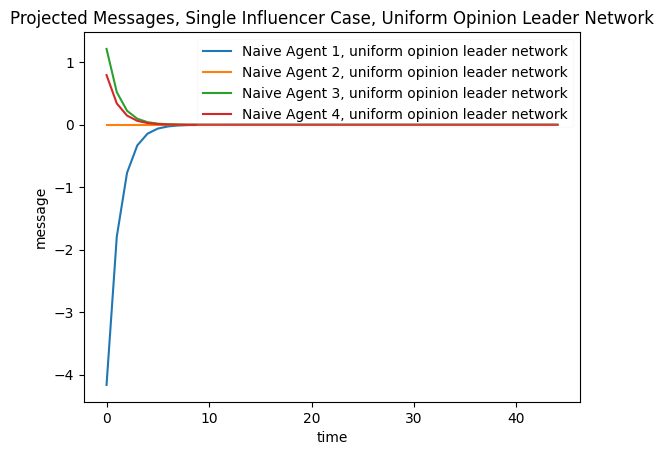

In [11]:
for i in range(4):
    plt.plot(range(len(tilde_rs)), [tilde_rs[j][i].item() for j in range(len(tilde_rs))], label = f"Naive Agent {i+1}, uniform opinion leader network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Projected Messages, Single Influencer Case, Uniform Opinion Leader Network")
plt.show()

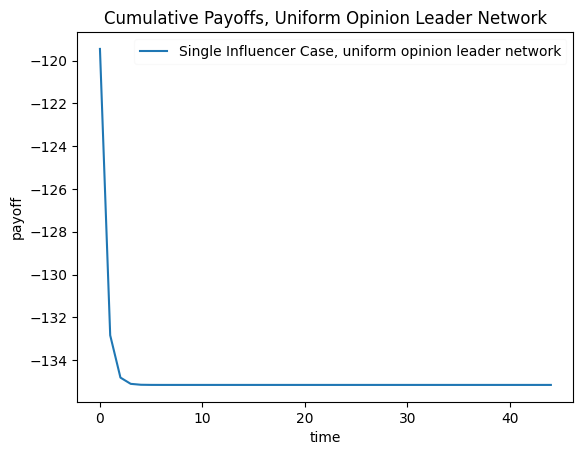

In [12]:
plt.plot(range(len(payoffs)), [payoffs[j] for j in range(len(payoffs))], label = f"Single Influencer Case, uniform opinion leader network")

plt.xlabel("time")
plt.ylabel("payoff")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Uniform Opinion Leader Network")
plt.show()

### Case 1: Equal $\alpha$, same agenda

In [13]:
b1 = 0
b2 = 0
alpha1 = 1
alpha2 = 1
xs, tilde_rs_1, tilde_rs_2, payoffs = run_simulation(A_1, b1, b2, alpha1, alpha2, delta, c, x0)

V:
[[ 0.73029674  0.47809144  0.48795004 -0.        ]
 [ 0.54772256 -0.83666003  0.         -0.        ]
 [ 0.36514837  0.23904572 -0.78072006  0.4472136 ]
 [ 0.18257419  0.11952286 -0.39036003 -0.89442719]]

U:
[[-0.5         0.8660254   0.          0.        ]
 [-0.5        -0.28867513  0.81649658 -0.        ]
 [-0.5        -0.28867513 -0.40824829 -0.70710678]
 [-0.5        -0.28867513 -0.40824829  0.70710678]]

S:
[[1.09544512 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]

U @ S @ V':
[[-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]]

Network:
[[0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]]

Unprojected Steady-State Opinions:
[[0.]
 [0.]
 [0.]
 [0.]]
Projected Steady-State Opinions:
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]]

Projected Steady-State Messages:
1:
[[-0.]
 [-0.]
 [ 0.]
 [ 0.]]

2:
[[-0

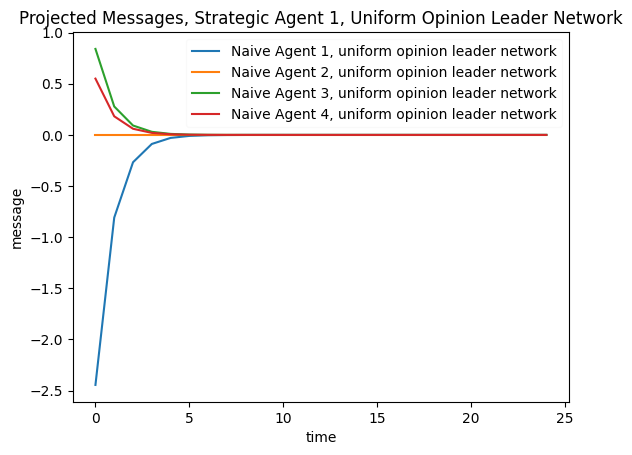

In [14]:
for i in range(4):
    plt.plot(range(len(tilde_rs_1)), [tilde_rs_1[j][i].item() for j in range(len(tilde_rs_1))], label = f"Naive Agent {i+1}, uniform opinion leader network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Projected Messages, Strategic Agent 1, Uniform Opinion Leader Network")
plt.show()

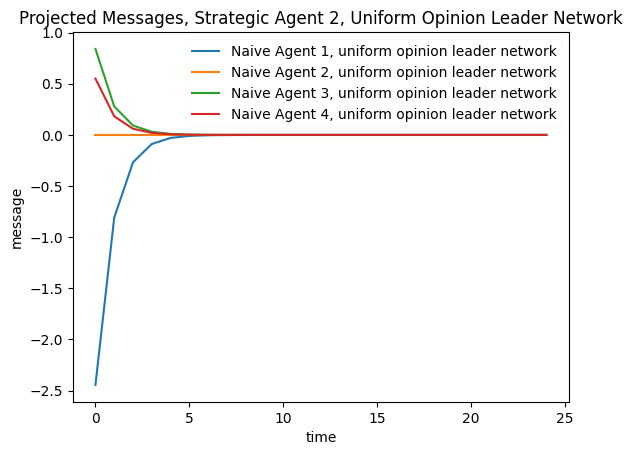

In [15]:
for i in range(4):
    plt.plot(range(len(tilde_rs_2)), [tilde_rs_2[j][i].item() for j in range(len(tilde_rs_2))], label = f"Naive Agent {i+1}, uniform opinion leader network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Projected Messages, Strategic Agent 2, Uniform Opinion Leader Network")
plt.show()

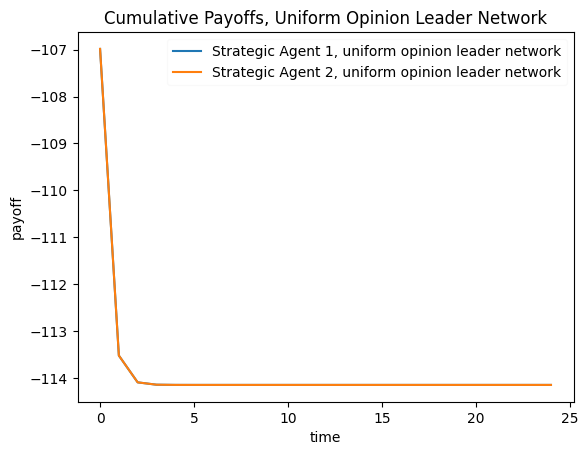

In [16]:
plt.plot(range(len(payoffs[0])), [payoffs[0][j] for j in range(len(payoffs[0]))], label = f"Strategic Agent 1, uniform opinion leader network")
plt.plot(range(len(payoffs[1])), [payoffs[1][j] for j in range(len(payoffs[1]))], label = f"Strategic Agent 2, uniform opinion leader network")

plt.xlabel("time")
plt.ylabel("payoff")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Uniform Opinion Leader Network")
plt.show()

### Case 2: Equal $\alpha$, different agendas

In [17]:
b1 = 0
b2 = 10
alpha1 = 1
alpha2 = 1
xs, tilde_rs_1, tilde_rs_2, payoffs = run_simulation(A_1, b1, b2, alpha1, alpha2, delta, c, x0)

V:
[[ 0.73029674  0.47809144  0.48795004 -0.        ]
 [ 0.54772256 -0.83666003  0.         -0.        ]
 [ 0.36514837  0.23904572 -0.78072006  0.4472136 ]
 [ 0.18257419  0.11952286 -0.39036003 -0.89442719]]

U:
[[-0.5         0.8660254   0.          0.        ]
 [-0.5        -0.28867513  0.81649658 -0.        ]
 [-0.5        -0.28867513 -0.40824829 -0.70710678]
 [-0.5        -0.28867513 -0.40824829  0.70710678]]

S:
[[1.09544512 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]

U @ S @ V':
[[-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]]

Network:
[[0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]]

Unprojected Steady-State Opinions:
[[5.]
 [5.]
 [5.]
 [5.]]
Projected Steady-State Opinions:
[[ 9.12870929]
 [ 0.        ]
 [-3.41565026]
 [-2.23606798]]

Projected Steady-State Messages:
1:
[[-17

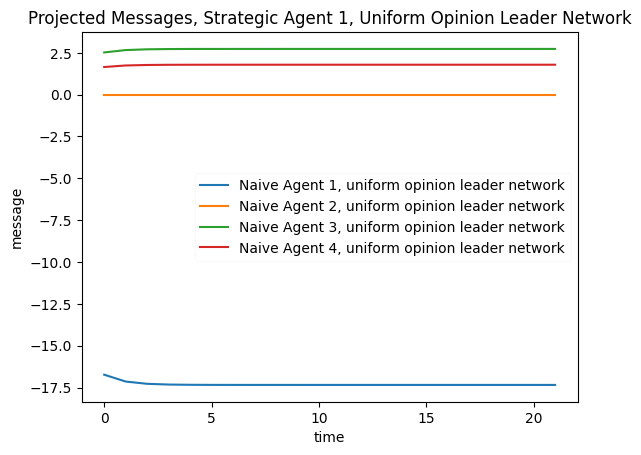

In [18]:
for i in range(4):
    plt.plot(range(len(tilde_rs_1)), [tilde_rs_1[j][i].item() for j in range(len(tilde_rs_1))], label = f"Naive Agent {i+1}, uniform opinion leader network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "right")
plt.title("Projected Messages, Strategic Agent 1, Uniform Opinion Leader Network")
plt.show()

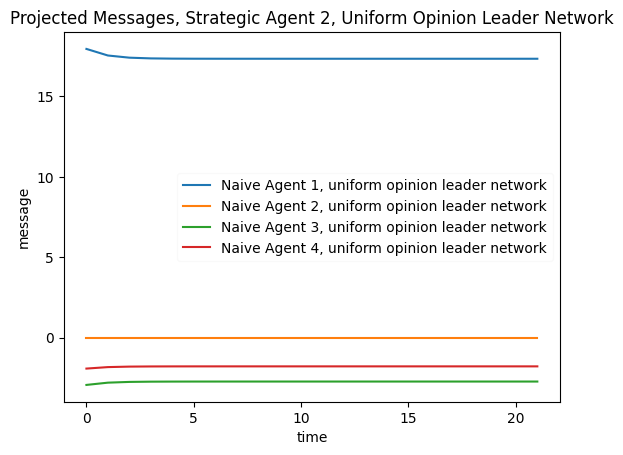

In [19]:
for i in range(4):
    plt.plot(range(len(tilde_rs_2)), [tilde_rs_2[j][i].item() for j in range(len(tilde_rs_2))], label = f"Naive Agent {i+1}, uniform opinion leader network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "right")
plt.title("Projected Messages, Strategic Agent 2, Uniform Opinion Leader Network")
plt.show()

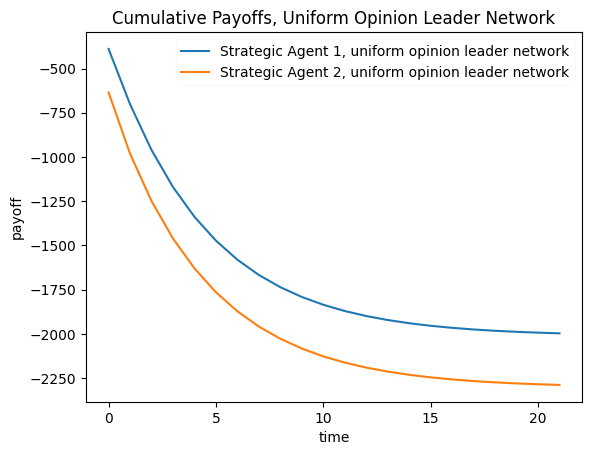

In [20]:
plt.plot(range(len(payoffs[0])), [payoffs[0][j] for j in range(len(payoffs[0]))], label = f"Strategic Agent 1, uniform opinion leader network")
plt.plot(range(len(payoffs[1])), [payoffs[1][j] for j in range(len(payoffs[1]))], label = f"Strategic Agent 2, uniform opinion leader network")

plt.xlabel("time")
plt.ylabel("payoff")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Uniform Opinion Leader Network")
plt.show()

### Case 3: Different $\alpha$, same agenda

In [21]:
b1 = 0
b2 = 0
alpha1 = 1
alpha2 = 0.5
xs, tilde_rs_1, tilde_rs_2, payoffs = run_simulation(A_1, b1, b2, alpha1, alpha2, delta, c, x0)

V:
[[ 0.73029674  0.47809144  0.48795004 -0.        ]
 [ 0.54772256 -0.83666003  0.         -0.        ]
 [ 0.36514837  0.23904572 -0.78072006  0.4472136 ]
 [ 0.18257419  0.11952286 -0.39036003 -0.89442719]]

U:
[[-0.5         0.8660254   0.          0.        ]
 [-0.5        -0.28867513  0.81649658 -0.        ]
 [-0.5        -0.28867513 -0.40824829 -0.70710678]
 [-0.5        -0.28867513 -0.40824829  0.70710678]]

S:
[[1.09544512 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]

U @ S @ V':
[[-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]]

Network:
[[0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]]

Unprojected Steady-State Opinions:
[[0.]
 [0.]
 [0.]
 [0.]]
Projected Steady-State Opinions:
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]]

Projected Steady-State Messages:
1:
[[-0.]
 [-0.]
 [ 0.]
 [ 0.]]

2:
[[-0

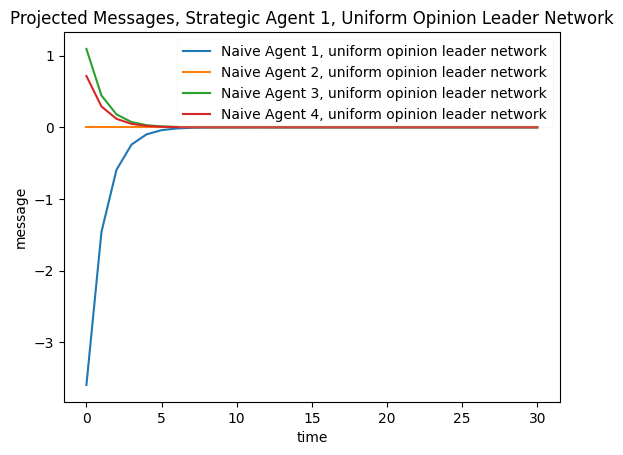

In [22]:
for i in range(4):
    plt.plot(range(len(tilde_rs_1)), [tilde_rs_1[j][i].item() for j in range(len(tilde_rs_1))], label = f"Naive Agent {i+1}, uniform opinion leader network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Projected Messages, Strategic Agent 1, Uniform Opinion Leader Network")
plt.show()

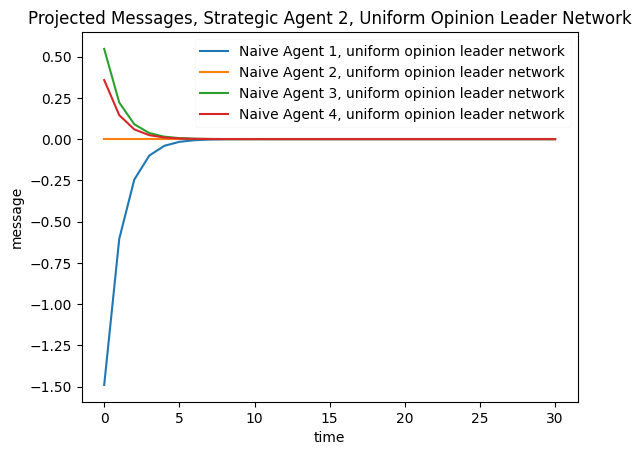

In [23]:
for i in range(4):
    plt.plot(range(len(tilde_rs_2)), [tilde_rs_2[j][i].item() for j in range(len(tilde_rs_2))], label = f"Naive Agent {i+1}, uniform opinion leader network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Projected Messages, Strategic Agent 2, Uniform Opinion Leader Network")
plt.show()

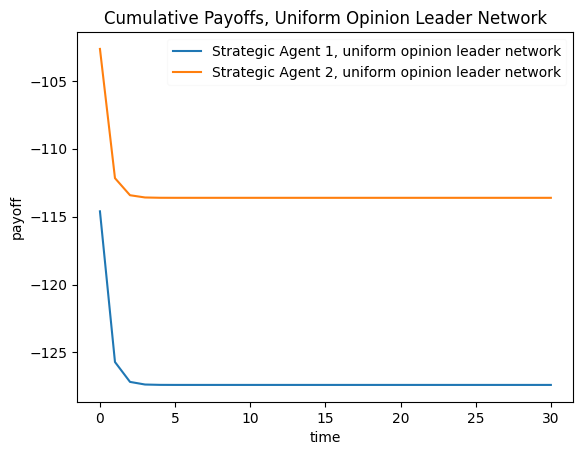

In [24]:
plt.plot(range(len(payoffs[0])), [payoffs[0][j] for j in range(len(payoffs[0]))], label = f"Strategic Agent 1, uniform opinion leader network")
plt.plot(range(len(payoffs[1])), [payoffs[1][j] for j in range(len(payoffs[1]))], label = f"Strategic Agent 2, uniform opinion leader network")

plt.xlabel("time")
plt.ylabel("payoff")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Uniform Opinion Leader Network")
plt.show()

### Case 4: Different $\alpha$, different agenda

In [25]:
b1 = 0
b2 = 10
alpha1 = 1
alpha2 = 0.5
xs, tilde_rs_1, tilde_rs_2, payoffs = run_simulation(A_1, b1, b2, alpha1, alpha2, delta, c, x0)

V:
[[ 0.73029674  0.47809144  0.48795004 -0.        ]
 [ 0.54772256 -0.83666003  0.         -0.        ]
 [ 0.36514837  0.23904572 -0.78072006  0.4472136 ]
 [ 0.18257419  0.11952286 -0.39036003 -0.89442719]]

U:
[[-0.5         0.8660254   0.          0.        ]
 [-0.5        -0.28867513  0.81649658 -0.        ]
 [-0.5        -0.28867513 -0.40824829 -0.70710678]
 [-0.5        -0.28867513 -0.40824829  0.70710678]]

S:
[[1.09544512 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]

U @ S @ V':
[[-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]
 [-0.4 -0.3 -0.2 -0.1]]

Network:
[[0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]
 [0.4 0.3 0.2 0.1]]

Unprojected Steady-State Opinions:
[[0.7829    ]
 [0.95677142]
 [1.13064285]
 [1.30451428]]
Projected Steady-State Opinions:
[[ 1.74681764]
 [ 0.        ]
 [-1.00992971]
 [-0.66115419]]

Projected

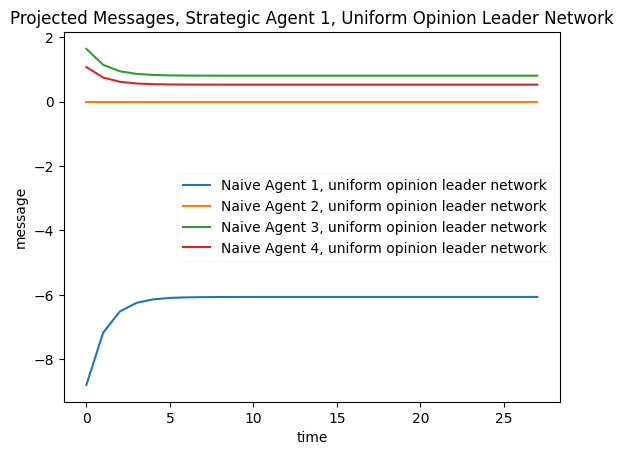

In [26]:
for i in range(4):
    plt.plot(range(len(tilde_rs_1)), [tilde_rs_1[j][i].item() for j in range(len(tilde_rs_1))], label = f"Naive Agent {i+1}, uniform opinion leader network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "right")
plt.title("Projected Messages, Strategic Agent 1, Uniform Opinion Leader Network")
plt.show()

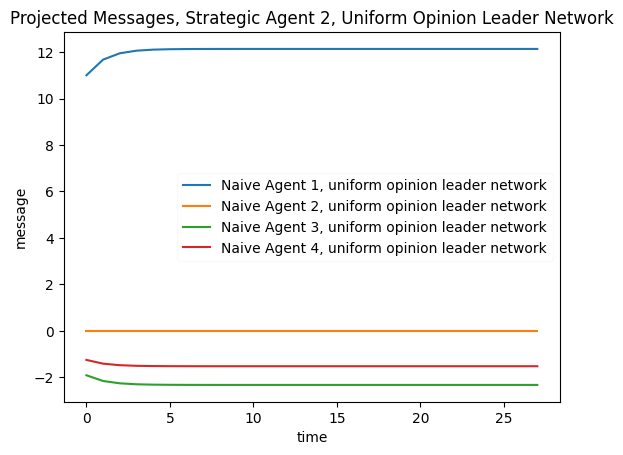

In [27]:
for i in range(4):
    plt.plot(range(len(tilde_rs_2)), [tilde_rs_2[j][i].item() for j in range(len(tilde_rs_2))], label = f"Naive Agent {i+1}, uniform opinion leader network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "right")
plt.title("Projected Messages, Strategic Agent 2, Uniform Opinion Leader Network")
plt.show()

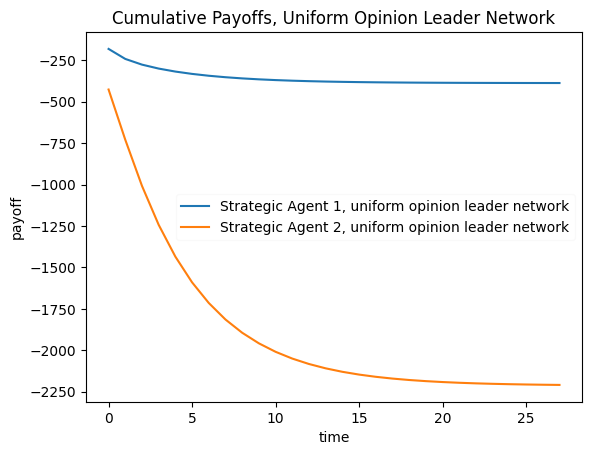

In [28]:
plt.plot(range(len(payoffs[0])), [payoffs[0][j] for j in range(len(payoffs[0]))], label = f"Strategic Agent 1, uniform opinion leader network")
plt.plot(range(len(payoffs[1])), [payoffs[1][j] for j in range(len(payoffs[1]))], label = f"Strategic Agent 2, uniform opinion leader network")

plt.xlabel("time")
plt.ylabel("payoff")
plt.legend(framealpha = 0.1, loc = "right")
plt.title("Cumulative Payoffs, Uniform Opinion Leader Network")
plt.show()